In [1]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1ZmBOBhZV0Nc5OigGfkcH5Az6tQrymdBV
!unzip /content/Dataset.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1ZmBOBhZV0Nc5OigGfkcH5Az6tQrymdBV
To: /content/Dataset.zip
100% 6.63M/6.63M [00:00<00:00, 148MB/s]
Archive:  /content/Dataset.zip
replace Dataset/log4j-1.1/buggy/SysoutConfigurator.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Dataset/log4j-1.1/buggy/SysoutConfigurator.png  
  inflating: Dataset/log4j-1.1/buggy/JMSAppender.png  
  inflating: Dataset/log4j-1.1/buggy/SocketAppender.png  
  inflating: Dataset/log4j-1.1/buggy/Priority.png  
  inflating: Dataset/log4j-1.1/buggy/SocketNode.png  
  inflating: Dataset/log4j-1.1/buggy/RollingFileAppender.png  
  inflating: Dataset/log4j-1.1/buggy/PropertyGetter.png  
  inflating: Dataset/log4j-1.1/buggy/SMTPAppender.png  
  inflating: Dataset/log4j-1.1/buggy/NDC.png  
  inflating: Dataset/log4j-1.1/buggy/PropertyConfigurator.png  
  inflating: Dataset/log4j-1.1/buggy/OptionHandler.png

In [2]:
import os
import cv2

import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Flatten, Dense, GlobalAveragePooling2D, BatchNormalization, Activation, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4177770221078887441
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10844127530650261250
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [4]:
os.listdir('/content/Dataset')

['log4j-1.1', 'ant-1.6-preprop', 'log4j-1.0', 'poi-3.0-preprop']

In [5]:
train_dir = "/content/Dataset/poi-3.0-preprop/"
valid_dir = "/content/Dataset/log4j-1.1/"

In [6]:
img_height,img_width=180,180
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              validation_split=0.8,
                                                              subset="training",
                                                              seed=123,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_dir,
                                                              validation_split=0.2,
                                                              subset="validation",
                                                              seed=123,
                                                              image_size=(img_height, img_width),
                                                              batch_size=batch_size)

Found 433 files belonging to 2 classes.
Using 87 files for training.
Found 102 files belonging to 2 classes.
Using 20 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['buggy', 'clean']


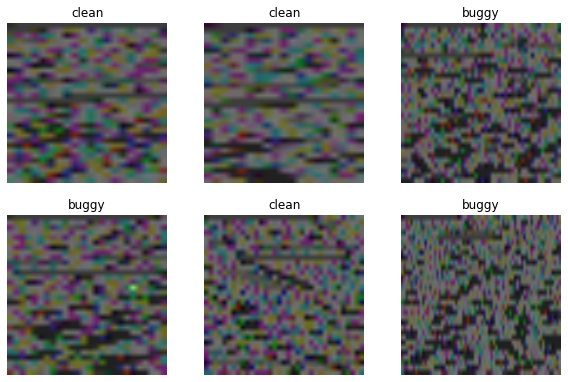

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.Resizing(180, 180),
  tf.keras.layers.RandomRotation(0.2)
])

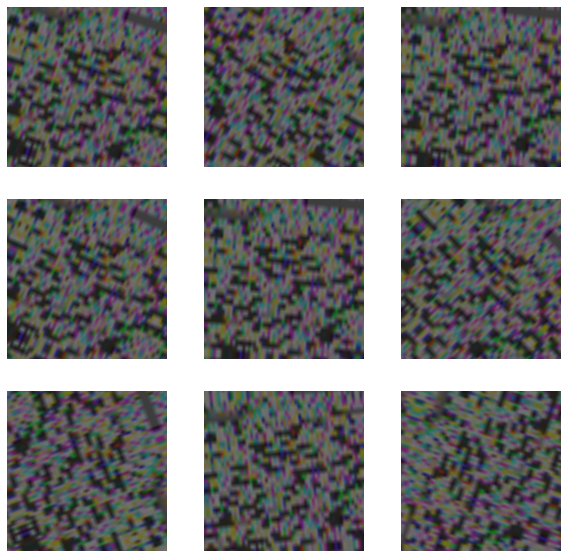

In [10]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                                                 input_shape=(180,180,3),
                                                 pooling='avg',classes=len(class_names),
                                                 weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [12]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
len(resnet_model.layers)

4

In [14]:
resnet_model.compile(optimizer=keras.optimizers.Adam(0.001),
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [15]:
epochs=5
history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
3/3 [==============================] - 13s 1s/step - loss: 1.5991 - accuracy: 0.5632 - precision: 0.3571 - recall: 0.3333 - val_loss: 1.0851 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/5
3/3 [==============================] - 0s 108ms/step - loss: 0.7707 - accuracy: 0.7241 - precision: 0.5789 - recall: 0.7333 - val_loss: 0.2864 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.8125
Epoch 3/5
3/3 [==============================] - 0s 112ms/step - loss: 0.6829 - accuracy: 0.7931 - precision: 0.6667 - recall: 0.8000 - val_loss: 1.3078 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.4375
Epoch 4/5
3/3 [==============================] - 0s 107ms/step - loss: 0.6300 - accuracy: 0.7701 - precision: 0.8125 - recall: 0.4333 - val_loss: 1.2157 - val_accuracy: 0.5000 - val_precision: 1.0000 - val_recall: 0.3750
Epoch 5/5
3/3 [==============================] - 0s 111ms/step - loss: 0.4183 - accuracy: 0.7816 - precision: 0.7619 -

In [16]:
for layer in pretrained_model.layers:
        layer.trainable=True
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,584,193
Non-trainable params: 53,120
_________________________________________________________________


In [17]:
resnet_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss = tf.keras.losses.BinaryCrossentropy(), 
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

epochs = 30
history = resnet_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/30
3/3 [==============================] - 10s 1s/step - loss: 0.6274 - accuracy: 0.6322 - precision_1: 0.4783 - recall_1: 0.7333 - val_loss: 0.4809 - val_accuracy: 0.7500 - val_precision_1: 0.8235 - val_recall_1: 0.8750
Epoch 2/30
3/3 [==============================] - 1s 249ms/step - loss: 0.4283 - accuracy: 0.8506 - precision_1: 0.7073 - recall_1: 0.9667 - val_loss: 0.5112 - val_accuracy: 0.7000 - val_precision_1: 0.8125 - val_recall_1: 0.8125
Epoch 3/30
3/3 [==============================] - 1s 244ms/step - loss: 0.3164 - accuracy: 0.9195 - precision_1: 0.8485 - recall_1: 0.9333 - val_loss: 0.5441 - val_accuracy: 0.6000 - val_precision_1: 0.7857 - val_recall_1: 0.6875
Epoch 4/30
3/3 [==============================] - 1s 245ms/step - loss: 0.2392 - accuracy: 0.9770 - precision_1: 1.0000 - recall_1: 0.9333 - val_loss: 0.5755 - val_accuracy: 0.5500 - val_precision_1: 0.7692 - val_recall_1: 0.6250
Epoch 5/30
3/3 [==============================] - 1s 249ms/step - loss: 0.2164 - a

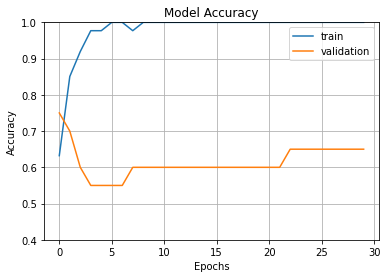

In [18]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

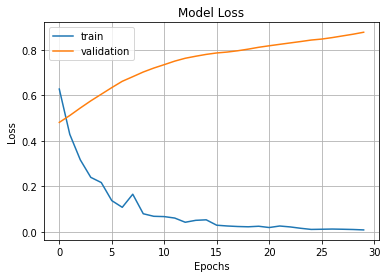

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [20]:
x = np.array(history.history['val_precision_1']).mean() * np.array(history.history['val_recall_1']).mean()
y = np.array(history.history['val_precision_1']).mean() + np.array(history.history['val_recall_1']).mean()

print("Accuracy: ", np.array(history.history['val_accuracy']).mean() )
print("Precision: ", np.array(history.history['val_precision_1']).mean() )
print("Recall: ", np.array(history.history['val_recall_1']).mean() )
print("F1_score: ", 2*x/y)

Accuracy:  0.6150000075499217
Precision:  0.8017870565255483
Recall:  0.6895833333333333
F1_score:  0.7414643536200642


In [21]:
model_json = resnet_model.to_json()
with open('sdp_resnet_model.json','w') as json_file:
    json_file.write(model_json)
    
resnet_model.save_weights('resnet_model.h5')

In [22]:
with open('sdp_resnet_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('resnet_model.h5')
model.compile(optimizer='adam',loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,584,193
Non-trainable params: 53,120
_________________________________________________________________


In [23]:
import numpy as np
import cv2
def predict(x):
    image=cv2.imread(x)
    plt.imshow(image)
    image_resized= cv2.resize(image, (180,180))
    image=np.expand_dims(image_resized,axis=0)
    print(image.shape)
    pred=resnet_model.predict(image)
    print(pred)
    output_class=class_names[np.argmax(pred)]
    print("The predicted is", output_class)

(1, 180, 180, 3)
1/1 [==============================] - 1s 1s/step
[[0.02175462]]
The predicted is buggy


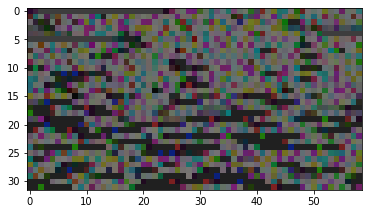

In [24]:
predict("/content/Dataset/poi-3.0-preprop/buggy/org.apache.poi.ddf.DefaultEscherRecordFactory.png")